In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.layers import Dense, Dropout, concatenate

from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"

In [3]:
dataset = pd.read_csv('../../data/TFT_energy.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,price,price_dayahead,gen_coal,gen_gas,load_actual,gen_lig,gen_oil,gen_oth_renew,pressure_Barcelona,pressure_Bilbao,...,wind_deg_Bilbao,clouds_all_Bilbao,gen_hyd_river,wind_deg_Seville,wind_speed_Barcelona,wind_speed_Valencia,wind_speed_Bilbao,gen_wind,wind_speed_Madrid,gen_hyd_pump
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,64.92,48.10,4755.0,5196.0,24382.0,328.0,158.0,71.0,1035.0,1035.0,...,229.0,0.0,1009.0,21.0,7.0,1.0,0.0,5890.0,1.0,920.0
2015-01-01 01:00:00+00:00,64.48,47.33,4581.0,4857.0,22734.0,323.0,157.0,73.0,1036.0,1036.0,...,224.0,0.0,973.0,27.0,7.0,0.0,1.0,5461.0,1.0,1164.0
2015-01-01 02:00:00+00:00,59.32,42.27,4131.0,4314.0,21286.0,254.0,160.0,75.0,1036.0,1035.0,...,225.0,0.0,949.0,27.0,7.0,0.0,1.0,5238.0,1.0,1503.0
2015-01-01 03:00:00+00:00,56.04,38.41,3840.0,4130.0,20264.0,187.0,156.0,74.0,1036.0,1035.0,...,221.0,0.0,953.0,27.0,7.0,0.0,1.0,4935.0,1.0,1826.0
2015-01-01 04:00:00+00:00,53.63,35.72,3590.0,4038.0,19905.0,178.0,156.0,74.0,1037.0,1035.0,...,224.0,0.0,952.0,57.0,5.0,2.0,1.0,4618.0,0.0,2109.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,77.02,68.85,2628.0,7634.0,30653.0,0.0,178.0,95.0,1027.0,1033.0,...,57.0,0.0,1135.0,30.0,1.0,2.0,0.0,3113.0,1.0,1.0
2018-12-31 19:00:00+00:00,76.16,68.40,2566.0,7241.0,29735.0,0.0,174.0,95.0,1027.0,1034.0,...,0.0,0.0,1172.0,30.0,3.0,1.0,1.0,3288.0,1.0,1.0
2018-12-31 20:00:00+00:00,74.30,66.88,2422.0,7025.0,28071.0,0.0,168.0,94.0,1028.0,1034.0,...,140.0,0.0,1148.0,50.0,4.0,3.0,1.0,3503.0,1.0,50.0


In [4]:
print(dataset.columns)

Index(['price', 'price_dayahead', 'gen_coal', 'gen_gas', 'load_actual',
       'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona',
       'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia',
       'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville',
       'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river',
       'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia',
       'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump'],
      dtype='object')


In [5]:
# specify the number of lag hours
n_hours = 24*3
K = 24

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [6]:
# Pre-processing
stages = dataset[['price']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (35063, 1)
stages_supervised.shape: (34968, 96)


In [7]:
stages.max()

price    116.8
dtype: float64

In [8]:
stages_supervised

,var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
time,,,,,,,,,,,,,,,,,,,,,
2015-01-04 00:00:00+00:00,64.92,64.48,59.32,56.04,53.63,51.73,51.43,48.98,54.20,58.94,...,52.07,52.15,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77
2015-01-04 01:00:00+00:00,64.48,59.32,56.04,53.63,51.73,51.43,48.98,54.20,58.94,59.86,...,52.15,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89
2015-01-04 02:00:00+00:00,59.32,56.04,53.63,51.73,51.43,48.98,54.20,58.94,59.86,60.12,...,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91
2015-01-04 03:00:00+00:00,56.04,53.63,51.73,51.43,48.98,54.20,58.94,59.86,60.12,62.05,...,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91,59.68
2015-01-04 04:00:00+00:00,53.63,51.73,51.43,48.98,54.20,58.94,59.86,60.12,62.05,62.06,...,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91,59.68,58.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-30 19:00:00+00:00,78.99,77.65,73.28,73.48,70.93,68.61,64.19,62.53,59.78,59.82,...,72.12,71.81,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02
2018-12-30 20:00:00+00:00,77.65,73.28,73.48,70.93,68.61,64.19,62.53,59.78,59.82,64.27,...,71.81,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16
2018-12-30 21:00:00+00:00,73.28,73.48,70.93,68.61,64.19,62.53,59.78,59.82,64.27,66.81,...,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16,74.30


#### Prior unknown covariates (6)

In [9]:
# prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
# print("prior_unknown.shape:", prior_unknown.shape)

# prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, K)
# print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

In [10]:
# prior_unknown_supervised

#### Prior known covariates (9)

In [11]:
prior_known = dataset[['price_dayahead', 'gen_coal', 'gen_gas', 'load_actual',
       'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona',
       'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia',
       'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville',
       'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river',
       'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia',
       'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, K)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (35063, 25)
prior_known_supervised.shape: (34968, 2400)


In [12]:
# prior_known_supervised

### N_out, N_in, K

In [13]:
past_cov = dataset[['price_dayahead', 'gen_coal', 'gen_gas', 'load_actual',
       'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona',
       'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia',
       'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville',
       'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river',
       'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia',
       'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump']]

past_cov_supervised = series_to_supervised(past_cov, n_hours, K)
print("past_cov_supervised.shape:", past_cov_supervised.shape)

past_cov_supervised.shape: (34968, 2400)


In [14]:
# past_cov_supervised  # 6 + 9 = 15 features

In [15]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [16]:
# past_ws_supervised  # 4

In [17]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*past_cov.shape[1]:(i+1)*past_cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [18]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised, past_ws_supervised], axis=1)
past_cov_ws_supervised = past_cov_ws_supervised[columns]


In [19]:
# past_cov_ws_supervised

In [20]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, K*prior_known.shape[1]:]  # shift 2 days for prior known covariates
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-48),shift_prior_known_supervised_var2(t-48),shift_prior_known_supervised_var3(t-48),shift_prior_known_supervised_var4(t-48),shift_prior_known_supervised_var5(t-48),shift_prior_known_supervised_var6(t-48),shift_prior_known_supervised_var7(t-48),shift_prior_known_supervised_var8(t-48),shift_prior_known_supervised_var9(t-48),shift_prior_known_supervised_var10(t-48),...,shift_prior_known_supervised_var16(t+23),shift_prior_known_supervised_var17(t+23),shift_prior_known_supervised_var18(t+23),shift_prior_known_supervised_var19(t+23),shift_prior_known_supervised_var20(t+23),shift_prior_known_supervised_var21(t+23),shift_prior_known_supervised_var22(t+23),shift_prior_known_supervised_var23(t+23),shift_prior_known_supervised_var24(t+23),shift_prior_known_supervised_var25(t+23)
0,7.00,1190.0,2902.0,24935.0,0.0,192.0,61.0,1038.0,1036.0,167.0,...,156.0,21.0,1182.0,132.0,2.0,1.0,0.0,7351.0,1.0,650.0
1,5.00,1023.0,2772.0,23214.0,0.0,189.0,60.0,1037.0,1036.0,167.0,...,163.0,12.0,1099.0,132.0,1.0,1.0,0.0,7403.0,1.0,938.0
2,4.00,1016.0,2936.0,22540.0,0.0,188.0,59.0,1037.0,1036.0,181.0,...,160.0,13.0,1076.0,108.0,2.0,2.0,0.0,7887.0,1.0,1021.0
3,4.00,1103.0,2893.0,22096.0,0.0,189.0,61.0,1037.0,1037.0,181.0,...,165.0,6.0,982.0,108.0,1.0,2.0,0.0,8348.0,1.0,2067.0
4,4.80,1120.0,2889.0,22066.0,0.0,190.0,59.0,1038.0,1037.0,171.0,...,162.0,20.0,982.0,108.0,1.0,2.0,0.0,8348.0,1.0,2067.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34963,66.00,2931.0,9149.0,32642.0,718.0,294.0,103.0,1028.0,1033.0,314.0,...,57.0,0.0,1135.0,30.0,1.0,2.0,0.0,3113.0,1.0,1.0
34964,62.09,2889.0,8024.0,32155.0,675.0,294.0,103.0,1028.0,1033.0,315.0,...,0.0,0.0,1172.0,30.0,3.0,1.0,1.0,3288.0,1.0,1.0
34965,61.77,2871.0,6871.0,30428.0,569.0,291.0,104.0,1029.0,1033.0,314.0,...,140.0,0.0,1148.0,50.0,4.0,3.0,1.0,3503.0,1.0,50.0
34966,58.43,2619.0,5822.0,28015.0,310.0,288.0,103.0,1029.0,1033.0,313.0,...,120.0,0.0,1128.0,60.0,5.0,2.0,1.0,3586.0,2.0,108.0


In [21]:
shift_prior_known_past_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], 
                                                     axis=1)


In [22]:
# shift_prior_known_past_cov_ws_supervised

In [23]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
0,50.54,48.68,48.02,47.06,46.79,47.63,47.44,50.84,54.84,59.95,...,52.07,52.15,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77
1,48.68,48.02,47.06,46.79,47.63,47.44,50.84,54.84,59.95,59.35,...,52.15,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89
2,48.02,47.06,46.79,47.63,47.44,50.84,54.84,59.95,59.35,57.03,...,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91
3,47.06,46.79,47.63,47.44,50.84,54.84,59.95,59.35,57.03,59.22,...,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91,59.68
4,46.79,47.63,47.44,50.84,54.84,59.95,59.35,57.03,59.22,58.56,...,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91,59.68,58.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34963,73.35,73.64,71.92,69.49,68.40,60.32,57.73,57.66,57.04,57.48,...,72.12,71.81,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02
34964,73.64,71.92,69.49,68.40,60.32,57.73,57.66,57.04,57.48,61.13,...,71.81,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16
34965,71.92,69.49,68.40,60.32,57.73,57.66,57.04,57.48,61.13,60.70,...,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16,74.30
34966,69.49,68.40,60.32,57.73,57.66,57.04,57.48,61.13,60.70,66.64,...,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16,74.30,69.89


### Concatenation

In [24]:
all_data = concat([shift_prior_known_past_cov_ws_supervised, future_ws_supervised], axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (34968, 3696)


### Train & Test set

In [25]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 27974


In [26]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

3672

### Normalization

In [27]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (27974, 3672) (27974, 24) (6994, 3672) (6994, 24)


In [28]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (27974, 72, 51) (27974, 24) (6994, 72, 51) (6994, 24)


### Model

In [48]:
model_input = Input(shape=(train_X.shape[1], train_X.shape[2]))

# 4 cnn with skip connection
x1 = layers.Conv1D(filters=256, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)


x1_merge1 = concatenate([model_input, x1])
x1 = layers.Conv1D(filters=128, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge1)


x1_merge2 = concatenate([model_input, x1])
x1 = layers.Conv1D(filters=64, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge2)


x1_merge3 = concatenate([model_input, x1])
x1 = layers.Conv1D(filters=32, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge3)


merge = concatenate([model_input, x1])
x = layers.Flatten()(merge)
x = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
x = Dense(64, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# x = Dense(64, activation='relu')(x)
x = Dense(train_y.shape[1])(x)

energy_pararcnn = Model(model_input, x)
energy_pararcnn.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 72, 51)]     0                                            
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 72, 256)      26368       input_7[0][0]                    
__________________________________________________________________________________________________
concatenate_24 (Concatenate)    (None, 72, 307)      0           input_7[0][0]                    
                                                                 conv1d_24[0][0]                  
__________________________________________________________________________________________________
conv1d_25 (Conv1D)              (None, 72, 128)      78720       concatenate_24[0][0]       

Epoch 1/6000

Epoch 00001: val_mae improved from inf to 0.19601, saving model to saved_model/energy_cnn_sc1_4layer_24h.h5
55/55 - 2s - loss: 0.3277 - mae: 0.1339 - val_loss: 0.2938 - val_mae: 0.1960
Epoch 2/6000

Epoch 00002: val_mae improved from 0.19601 to 0.14130, saving model to saved_model/energy_cnn_sc1_4layer_24h.h5
55/55 - 2s - loss: 0.2346 - mae: 0.0757 - val_loss: 0.2330 - val_mae: 0.1413
Epoch 3/6000

Epoch 00003: val_mae improved from 0.14130 to 0.11121, saving model to saved_model/energy_cnn_sc1_4layer_24h.h5
55/55 - 2s - loss: 0.1981 - mae: 0.0666 - val_loss: 0.1936 - val_mae: 0.1112
Epoch 4/6000

Epoch 00004: val_mae improved from 0.11121 to 0.09369, saving model to saved_model/energy_cnn_sc1_4layer_24h.h5
55/55 - 2s - loss: 0.1707 - mae: 0.0612 - val_loss: 0.1658 - val_mae: 0.0937
Epoch 5/6000

Epoch 00005: val_mae improved from 0.09369 to 0.09280, saving model to saved_model/energy_cnn_sc1_4layer_24h.h5
55/55 - 2s - loss: 0.1492 - mae: 0.0577 - val_loss: 0.1466 - val_m

Epoch 52/6000

Epoch 00052: val_mae improved from 0.04896 to 0.04788, saving model to saved_model/energy_cnn_sc1_4layer_24h.h5
55/55 - 2s - loss: 0.0097 - mae: 0.0426 - val_loss: 0.0103 - val_mae: 0.0479
Epoch 53/6000

Epoch 00053: val_mae did not improve from 0.04788
55/55 - 2s - loss: 0.0096 - mae: 0.0434 - val_loss: 0.0104 - val_mae: 0.0491
Epoch 54/6000

Epoch 00054: val_mae did not improve from 0.04788
55/55 - 2s - loss: 0.0095 - mae: 0.0438 - val_loss: 0.0113 - val_mae: 0.0568
Epoch 55/6000

Epoch 00055: val_mae did not improve from 0.04788
55/55 - 2s - loss: 0.0093 - mae: 0.0430 - val_loss: 0.0101 - val_mae: 0.0501
Epoch 56/6000

Epoch 00056: val_mae did not improve from 0.04788
55/55 - 2s - loss: 0.0092 - mae: 0.0433 - val_loss: 0.0099 - val_mae: 0.0492
Epoch 57/6000

Epoch 00057: val_mae improved from 0.04788 to 0.04735, saving model to saved_model/energy_cnn_sc1_4layer_24h.h5
55/55 - 2s - loss: 0.0091 - mae: 0.0432 - val_loss: 0.0096 - val_mae: 0.0473
Epoch 58/6000

Epoch 000

Epoch 107/6000

Epoch 00107: val_mae did not improve from 0.04446
55/55 - 2s - loss: 0.0062 - mae: 0.0417 - val_loss: 0.0071 - val_mae: 0.0492
Epoch 108/6000

Epoch 00108: val_mae did not improve from 0.04446
55/55 - 2s - loss: 0.0060 - mae: 0.0408 - val_loss: 0.0068 - val_mae: 0.0465
Epoch 109/6000

Epoch 00109: val_mae did not improve from 0.04446
55/55 - 2s - loss: 0.0060 - mae: 0.0410 - val_loss: 0.0069 - val_mae: 0.0467
Epoch 110/6000

Epoch 00110: val_mae did not improve from 0.04446
55/55 - 2s - loss: 0.0060 - mae: 0.0410 - val_loss: 0.0072 - val_mae: 0.0508
Epoch 111/6000

Epoch 00111: val_mae did not improve from 0.04446
55/55 - 2s - loss: 0.0060 - mae: 0.0408 - val_loss: 0.0070 - val_mae: 0.0483
Epoch 112/6000

Epoch 00112: val_mae improved from 0.04446 to 0.04387, saving model to saved_model/energy_cnn_sc1_4layer_24h.h5
55/55 - 2s - loss: 0.0060 - mae: 0.0410 - val_loss: 0.0064 - val_mae: 0.0439
Epoch 113/6000

Epoch 00113: val_mae did not improve from 0.04387
55/55 - 2s - l

Epoch 163/6000

Epoch 00163: val_mae did not improve from 0.04361
55/55 - 2s - loss: 0.0052 - mae: 0.0401 - val_loss: 0.0060 - val_mae: 0.0460
Epoch 164/6000

Epoch 00164: val_mae did not improve from 0.04361
55/55 - 2s - loss: 0.0052 - mae: 0.0403 - val_loss: 0.0073 - val_mae: 0.0559
Epoch 165/6000

Epoch 00165: val_mae did not improve from 0.04361
55/55 - 2s - loss: 0.0052 - mae: 0.0403 - val_loss: 0.0064 - val_mae: 0.0491
Epoch 166/6000

Epoch 00166: val_mae did not improve from 0.04361
55/55 - 2s - loss: 0.0053 - mae: 0.0414 - val_loss: 0.0076 - val_mae: 0.0586
Epoch 167/6000

Epoch 00167: val_mae did not improve from 0.04361
55/55 - 2s - loss: 0.0051 - mae: 0.0398 - val_loss: 0.0059 - val_mae: 0.0451
Epoch 168/6000

Epoch 00168: val_mae improved from 0.04361 to 0.04356, saving model to saved_model/energy_cnn_sc1_4layer_24h.h5
55/55 - 2s - loss: 0.0051 - mae: 0.0393 - val_loss: 0.0057 - val_mae: 0.0436
Epoch 169/6000

Epoch 00169: val_mae did not improve from 0.04356
55/55 - 2s - l

Epoch 220/6000

Epoch 00220: val_mae did not improve from 0.04343
55/55 - 2s - loss: 0.0049 - mae: 0.0392 - val_loss: 0.0055 - val_mae: 0.0438
Epoch 221/6000

Epoch 00221: val_mae did not improve from 0.04343
55/55 - 2s - loss: 0.0049 - mae: 0.0395 - val_loss: 0.0060 - val_mae: 0.0482
Epoch 222/6000

Epoch 00222: val_mae did not improve from 0.04343
55/55 - 2s - loss: 0.0049 - mae: 0.0390 - val_loss: 0.0056 - val_mae: 0.0450
Epoch 223/6000

Epoch 00223: val_mae did not improve from 0.04343
55/55 - 2s - loss: 0.0048 - mae: 0.0385 - val_loss: 0.0067 - val_mae: 0.0538
Epoch 224/6000

Epoch 00224: val_mae did not improve from 0.04343
55/55 - 2s - loss: 0.0049 - mae: 0.0397 - val_loss: 0.0057 - val_mae: 0.0457
Epoch 225/6000

Epoch 00225: val_mae did not improve from 0.04343
55/55 - 2s - loss: 0.0049 - mae: 0.0396 - val_loss: 0.0055 - val_mae: 0.0438
Epoch 226/6000

Epoch 00226: val_mae did not improve from 0.04343
55/55 - 2s - loss: 0.0049 - mae: 0.0391 - val_loss: 0.0057 - val_mae: 0.0460

Epoch 277/6000

Epoch 00277: val_mae did not improve from 0.04307
55/55 - 2s - loss: 0.0049 - mae: 0.0403 - val_loss: 0.0063 - val_mae: 0.0511
Epoch 278/6000

Epoch 00278: val_mae did not improve from 0.04307
55/55 - 2s - loss: 0.0047 - mae: 0.0390 - val_loss: 0.0055 - val_mae: 0.0448
Epoch 279/6000

Epoch 00279: val_mae did not improve from 0.04307
55/55 - 2s - loss: 0.0048 - mae: 0.0392 - val_loss: 0.0063 - val_mae: 0.0514
Epoch 280/6000

Epoch 00280: val_mae did not improve from 0.04307
55/55 - 2s - loss: 0.0046 - mae: 0.0380 - val_loss: 0.0058 - val_mae: 0.0474
Epoch 281/6000

Epoch 00281: val_mae did not improve from 0.04307
55/55 - 1s - loss: 0.0047 - mae: 0.0389 - val_loss: 0.0056 - val_mae: 0.0457
Epoch 282/6000

Epoch 00282: val_mae did not improve from 0.04307
55/55 - 2s - loss: 0.0048 - mae: 0.0397 - val_loss: 0.0057 - val_mae: 0.0465
Epoch 283/6000

Epoch 00283: val_mae did not improve from 0.04307
55/55 - 2s - loss: 0.0047 - mae: 0.0384 - val_loss: 0.0055 - val_mae: 0.0444

Epoch 334/6000

Epoch 00334: val_mae did not improve from 0.04300
55/55 - 2s - loss: 0.0046 - mae: 0.0383 - val_loss: 0.0057 - val_mae: 0.0470
Epoch 335/6000

Epoch 00335: val_mae did not improve from 0.04300
55/55 - 2s - loss: 0.0046 - mae: 0.0384 - val_loss: 0.0054 - val_mae: 0.0443
Epoch 336/6000

Epoch 00336: val_mae did not improve from 0.04300
55/55 - 2s - loss: 0.0046 - mae: 0.0385 - val_loss: 0.0058 - val_mae: 0.0475
Epoch 337/6000

Epoch 00337: val_mae did not improve from 0.04300
55/55 - 2s - loss: 0.0046 - mae: 0.0386 - val_loss: 0.0053 - val_mae: 0.0436
Epoch 338/6000

Epoch 00338: val_mae did not improve from 0.04300
55/55 - 2s - loss: 0.0046 - mae: 0.0384 - val_loss: 0.0058 - val_mae: 0.0484
Epoch 339/6000

Epoch 00339: val_mae did not improve from 0.04300
55/55 - 2s - loss: 0.0046 - mae: 0.0382 - val_loss: 0.0057 - val_mae: 0.0469
Epoch 340/6000

Epoch 00340: val_mae did not improve from 0.04300
55/55 - 2s - loss: 0.0046 - mae: 0.0387 - val_loss: 0.0058 - val_mae: 0.0481

Epoch 392/6000

Epoch 00392: val_mae did not improve from 0.04300
55/55 - 2s - loss: 0.0046 - mae: 0.0390 - val_loss: 0.0058 - val_mae: 0.0483
Epoch 393/6000

Epoch 00393: val_mae did not improve from 0.04300
55/55 - 2s - loss: 0.0045 - mae: 0.0383 - val_loss: 0.0061 - val_mae: 0.0513
Epoch 394/6000

Epoch 00394: val_mae did not improve from 0.04300
55/55 - 2s - loss: 0.0046 - mae: 0.0391 - val_loss: 0.0056 - val_mae: 0.0462
Epoch 395/6000

Epoch 00395: val_mae did not improve from 0.04300
55/55 - 2s - loss: 0.0046 - mae: 0.0388 - val_loss: 0.0061 - val_mae: 0.0499
Epoch 396/6000

Epoch 00396: val_mae did not improve from 0.04300
55/55 - 2s - loss: 0.0046 - mae: 0.0392 - val_loss: 0.0054 - val_mae: 0.0447
Epoch 397/6000

Epoch 00397: val_mae did not improve from 0.04300
55/55 - 2s - loss: 0.0045 - mae: 0.0382 - val_loss: 0.0054 - val_mae: 0.0444
Epoch 398/6000

Epoch 00398: val_mae did not improve from 0.04300
55/55 - 2s - loss: 0.0046 - mae: 0.0387 - val_loss: 0.0055 - val_mae: 0.0456

Epoch 450/6000

Epoch 00450: val_mae did not improve from 0.04300
55/55 - 2s - loss: 0.0045 - mae: 0.0385 - val_loss: 0.0054 - val_mae: 0.0448
Epoch 451/6000

Epoch 00451: val_mae did not improve from 0.04300
55/55 - 2s - loss: 0.0045 - mae: 0.0381 - val_loss: 0.0057 - val_mae: 0.0482
Epoch 452/6000

Epoch 00452: val_mae did not improve from 0.04300
55/55 - 2s - loss: 0.0045 - mae: 0.0379 - val_loss: 0.0054 - val_mae: 0.0447
Epoch 453/6000

Epoch 00453: val_mae did not improve from 0.04300
55/55 - 2s - loss: 0.0046 - mae: 0.0388 - val_loss: 0.0060 - val_mae: 0.0498
Epoch 454/6000

Epoch 00454: val_mae did not improve from 0.04300
55/55 - 2s - loss: 0.0046 - mae: 0.0393 - val_loss: 0.0057 - val_mae: 0.0474
Epoch 455/6000

Epoch 00455: val_mae did not improve from 0.04300
55/55 - 1s - loss: 0.0046 - mae: 0.0392 - val_loss: 0.0054 - val_mae: 0.0455
Epoch 456/6000

Epoch 00456: val_mae did not improve from 0.04300
55/55 - 2s - loss: 0.0044 - mae: 0.0374 - val_loss: 0.0054 - val_mae: 0.0447

Epoch 507/6000

Epoch 00507: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0045 - mae: 0.0381 - val_loss: 0.0052 - val_mae: 0.0434
Epoch 508/6000

Epoch 00508: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0378 - val_loss: 0.0053 - val_mae: 0.0451
Epoch 509/6000

Epoch 00509: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0379 - val_loss: 0.0060 - val_mae: 0.0502
Epoch 510/6000

Epoch 00510: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0046 - mae: 0.0393 - val_loss: 0.0052 - val_mae: 0.0437
Epoch 511/6000

Epoch 00511: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0045 - mae: 0.0384 - val_loss: 0.0053 - val_mae: 0.0440
Epoch 512/6000

Epoch 00512: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0045 - mae: 0.0382 - val_loss: 0.0058 - val_mae: 0.0482
Epoch 513/6000

Epoch 00513: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0045 - mae: 0.0388 - val_loss: 0.0052 - val_mae: 0.0437

Epoch 565/6000

Epoch 00565: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0383 - val_loss: 0.0052 - val_mae: 0.0437
Epoch 566/6000

Epoch 00566: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0046 - mae: 0.0394 - val_loss: 0.0058 - val_mae: 0.0481
Epoch 567/6000

Epoch 00567: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0045 - mae: 0.0386 - val_loss: 0.0055 - val_mae: 0.0462
Epoch 568/6000

Epoch 00568: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0044 - mae: 0.0379 - val_loss: 0.0057 - val_mae: 0.0478
Epoch 569/6000

Epoch 00569: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0383 - val_loss: 0.0054 - val_mae: 0.0458
Epoch 570/6000

Epoch 00570: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0045 - mae: 0.0384 - val_loss: 0.0057 - val_mae: 0.0481
Epoch 571/6000

Epoch 00571: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0378 - val_loss: 0.0063 - val_mae: 0.0526

Epoch 623/6000

Epoch 00623: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0379 - val_loss: 0.0054 - val_mae: 0.0453
Epoch 624/6000

Epoch 00624: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0381 - val_loss: 0.0062 - val_mae: 0.0521
Epoch 625/6000

Epoch 00625: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0045 - mae: 0.0385 - val_loss: 0.0051 - val_mae: 0.0434
Epoch 626/6000

Epoch 00626: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0045 - mae: 0.0390 - val_loss: 0.0065 - val_mae: 0.0542
Epoch 627/6000

Epoch 00627: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0044 - mae: 0.0384 - val_loss: 0.0056 - val_mae: 0.0472
Epoch 628/6000

Epoch 00628: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0381 - val_loss: 0.0053 - val_mae: 0.0447
Epoch 629/6000

Epoch 00629: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0044 - mae: 0.0382 - val_loss: 0.0053 - val_mae: 0.0443

Epoch 681/6000

Epoch 00681: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0043 - mae: 0.0377 - val_loss: 0.0057 - val_mae: 0.0475
Epoch 682/6000

Epoch 00682: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0045 - mae: 0.0393 - val_loss: 0.0069 - val_mae: 0.0583
Epoch 683/6000

Epoch 00683: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0044 - mae: 0.0380 - val_loss: 0.0053 - val_mae: 0.0449
Epoch 684/6000

Epoch 00684: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0376 - val_loss: 0.0056 - val_mae: 0.0475
Epoch 685/6000

Epoch 00685: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0043 - mae: 0.0374 - val_loss: 0.0054 - val_mae: 0.0455
Epoch 686/6000

Epoch 00686: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0381 - val_loss: 0.0058 - val_mae: 0.0492
Epoch 687/6000

Epoch 00687: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0386 - val_loss: 0.0053 - val_mae: 0.0450

Epoch 739/6000

Epoch 00739: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0043 - mae: 0.0378 - val_loss: 0.0052 - val_mae: 0.0443
Epoch 740/6000

Epoch 00740: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0379 - val_loss: 0.0056 - val_mae: 0.0475
Epoch 741/6000

Epoch 00741: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0380 - val_loss: 0.0054 - val_mae: 0.0455
Epoch 742/6000

Epoch 00742: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0386 - val_loss: 0.0053 - val_mae: 0.0452
Epoch 743/6000

Epoch 00743: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0387 - val_loss: 0.0059 - val_mae: 0.0502
Epoch 744/6000

Epoch 00744: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0380 - val_loss: 0.0062 - val_mae: 0.0521
Epoch 745/6000

Epoch 00745: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0381 - val_loss: 0.0060 - val_mae: 0.0504

Epoch 797/6000

Epoch 00797: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0375 - val_loss: 0.0055 - val_mae: 0.0468
Epoch 798/6000

Epoch 00798: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0381 - val_loss: 0.0054 - val_mae: 0.0461
Epoch 799/6000

Epoch 00799: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0378 - val_loss: 0.0052 - val_mae: 0.0445
Epoch 800/6000

Epoch 00800: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0380 - val_loss: 0.0064 - val_mae: 0.0540
Epoch 801/6000

Epoch 00801: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0045 - mae: 0.0391 - val_loss: 0.0059 - val_mae: 0.0502
Epoch 802/6000

Epoch 00802: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0045 - mae: 0.0391 - val_loss: 0.0052 - val_mae: 0.0440
Epoch 803/6000

Epoch 00803: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0383 - val_loss: 0.0054 - val_mae: 0.0462

Epoch 855/6000

Epoch 00855: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0388 - val_loss: 0.0054 - val_mae: 0.0458
Epoch 856/6000

Epoch 00856: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0383 - val_loss: 0.0057 - val_mae: 0.0482
Epoch 857/6000

Epoch 00857: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0044 - mae: 0.0380 - val_loss: 0.0053 - val_mae: 0.0453
Epoch 858/6000

Epoch 00858: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0044 - mae: 0.0388 - val_loss: 0.0067 - val_mae: 0.0557
Epoch 859/6000

Epoch 00859: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0044 - mae: 0.0386 - val_loss: 0.0053 - val_mae: 0.0457
Epoch 860/6000

Epoch 00860: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0381 - val_loss: 0.0055 - val_mae: 0.0470
Epoch 861/6000

Epoch 00861: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0377 - val_loss: 0.0052 - val_mae: 0.0446

Epoch 913/6000

Epoch 00913: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0043 - mae: 0.0381 - val_loss: 0.0052 - val_mae: 0.0441
Epoch 914/6000

Epoch 00914: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0380 - val_loss: 0.0052 - val_mae: 0.0447
Epoch 915/6000

Epoch 00915: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0044 - mae: 0.0383 - val_loss: 0.0058 - val_mae: 0.0496
Epoch 916/6000

Epoch 00916: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0043 - mae: 0.0377 - val_loss: 0.0069 - val_mae: 0.0558
Epoch 917/6000

Epoch 00917: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0382 - val_loss: 0.0055 - val_mae: 0.0475
Epoch 918/6000

Epoch 00918: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0391 - val_loss: 0.0052 - val_mae: 0.0447
Epoch 919/6000

Epoch 00919: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0044 - mae: 0.0383 - val_loss: 0.0056 - val_mae: 0.0479

Epoch 971/6000

Epoch 00971: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0388 - val_loss: 0.0055 - val_mae: 0.0464
Epoch 972/6000

Epoch 00972: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0375 - val_loss: 0.0054 - val_mae: 0.0460
Epoch 973/6000

Epoch 00973: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0373 - val_loss: 0.0059 - val_mae: 0.0503
Epoch 974/6000

Epoch 00974: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0377 - val_loss: 0.0056 - val_mae: 0.0484
Epoch 975/6000

Epoch 00975: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0375 - val_loss: 0.0055 - val_mae: 0.0472
Epoch 976/6000

Epoch 00976: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0370 - val_loss: 0.0052 - val_mae: 0.0449
Epoch 977/6000

Epoch 00977: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0389 - val_loss: 0.0065 - val_mae: 0.0551


Epoch 01028: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0377 - val_loss: 0.0051 - val_mae: 0.0444
Epoch 1029/6000

Epoch 01029: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0383 - val_loss: 0.0056 - val_mae: 0.0475
Epoch 1030/6000

Epoch 01030: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0374 - val_loss: 0.0058 - val_mae: 0.0503
Epoch 1031/6000

Epoch 01031: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0376 - val_loss: 0.0054 - val_mae: 0.0459
Epoch 1032/6000

Epoch 01032: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0377 - val_loss: 0.0053 - val_mae: 0.0455
Epoch 1033/6000

Epoch 01033: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0376 - val_loss: 0.0052 - val_mae: 0.0448
Epoch 1034/6000

Epoch 01034: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0381 - val_loss: 0.0062 - val_mae: 0.0529
Epoch 10


Epoch 01085: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0377 - val_loss: 0.0056 - val_mae: 0.0482
Epoch 1086/6000

Epoch 01086: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0382 - val_loss: 0.0066 - val_mae: 0.0557
Epoch 1087/6000

Epoch 01087: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0389 - val_loss: 0.0053 - val_mae: 0.0458
Epoch 1088/6000

Epoch 01088: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0373 - val_loss: 0.0056 - val_mae: 0.0489
Epoch 1089/6000

Epoch 01089: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0371 - val_loss: 0.0051 - val_mae: 0.0444
Epoch 1090/6000

Epoch 01090: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0378 - val_loss: 0.0055 - val_mae: 0.0470
Epoch 1091/6000

Epoch 01091: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0369 - val_loss: 0.0051 - val_mae: 0.0436
Epoch 10


Epoch 01142: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0374 - val_loss: 0.0059 - val_mae: 0.0500
Epoch 1143/6000

Epoch 01143: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0377 - val_loss: 0.0058 - val_mae: 0.0495
Epoch 1144/6000

Epoch 01144: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0043 - mae: 0.0381 - val_loss: 0.0055 - val_mae: 0.0472
Epoch 1145/6000

Epoch 01145: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0042 - mae: 0.0373 - val_loss: 0.0055 - val_mae: 0.0475
Epoch 1146/6000

Epoch 01146: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0375 - val_loss: 0.0060 - val_mae: 0.0509
Epoch 1147/6000

Epoch 01147: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0373 - val_loss: 0.0053 - val_mae: 0.0453
Epoch 1148/6000

Epoch 01148: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0384 - val_loss: 0.0055 - val_mae: 0.0475
Epoch 11


Epoch 01199: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0374 - val_loss: 0.0055 - val_mae: 0.0469
Epoch 1200/6000

Epoch 01200: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0377 - val_loss: 0.0056 - val_mae: 0.0482
Epoch 1201/6000

Epoch 01201: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0378 - val_loss: 0.0056 - val_mae: 0.0482
Epoch 1202/6000

Epoch 01202: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0380 - val_loss: 0.0053 - val_mae: 0.0458
Epoch 1203/6000

Epoch 01203: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0368 - val_loss: 0.0055 - val_mae: 0.0471
Epoch 1204/6000

Epoch 01204: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0389 - val_loss: 0.0052 - val_mae: 0.0450
Epoch 1205/6000

Epoch 01205: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0371 - val_loss: 0.0053 - val_mae: 0.0452
Epoch 12


Epoch 01256: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0388 - val_loss: 0.0063 - val_mae: 0.0538
Epoch 1257/6000

Epoch 01257: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0364 - val_loss: 0.0058 - val_mae: 0.0497
Epoch 1258/6000

Epoch 01258: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0391 - val_loss: 0.0054 - val_mae: 0.0462
Epoch 1259/6000

Epoch 01259: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0043 - mae: 0.0382 - val_loss: 0.0053 - val_mae: 0.0455
Epoch 1260/6000

Epoch 01260: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0370 - val_loss: 0.0052 - val_mae: 0.0445
Epoch 1261/6000

Epoch 01261: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0368 - val_loss: 0.0051 - val_mae: 0.0442
Epoch 1262/6000

Epoch 01262: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0377 - val_loss: 0.0054 - val_mae: 0.0467
Epoch 12


Epoch 01313: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0044 - mae: 0.0390 - val_loss: 0.0060 - val_mae: 0.0513
Epoch 1314/6000

Epoch 01314: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0042 - mae: 0.0374 - val_loss: 0.0052 - val_mae: 0.0450
Epoch 1315/6000

Epoch 01315: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0382 - val_loss: 0.0065 - val_mae: 0.0556
Epoch 1316/6000

Epoch 01316: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0372 - val_loss: 0.0056 - val_mae: 0.0481
Epoch 1317/6000

Epoch 01317: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0381 - val_loss: 0.0051 - val_mae: 0.0439
Epoch 1318/6000

Epoch 01318: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0043 - mae: 0.0377 - val_loss: 0.0063 - val_mae: 0.0534
Epoch 1319/6000

Epoch 01319: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0370 - val_loss: 0.0052 - val_mae: 0.0448
Epoch 13


Epoch 01370: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0378 - val_loss: 0.0060 - val_mae: 0.0508
Epoch 1371/6000

Epoch 01371: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0372 - val_loss: 0.0053 - val_mae: 0.0454
Epoch 1372/6000

Epoch 01372: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0375 - val_loss: 0.0060 - val_mae: 0.0509
Epoch 1373/6000

Epoch 01373: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0371 - val_loss: 0.0058 - val_mae: 0.0499
Epoch 1374/6000

Epoch 01374: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0368 - val_loss: 0.0058 - val_mae: 0.0501
Epoch 1375/6000

Epoch 01375: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0380 - val_loss: 0.0065 - val_mae: 0.0559
Epoch 1376/6000

Epoch 01376: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0042 - mae: 0.0376 - val_loss: 0.0054 - val_mae: 0.0469
Epoch 13


Epoch 01427: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0365 - val_loss: 0.0058 - val_mae: 0.0496
Epoch 1428/6000

Epoch 01428: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0381 - val_loss: 0.0068 - val_mae: 0.0566
Epoch 1429/6000

Epoch 01429: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0375 - val_loss: 0.0057 - val_mae: 0.0483
Epoch 1430/6000

Epoch 01430: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0042 - mae: 0.0372 - val_loss: 0.0063 - val_mae: 0.0536
Epoch 1431/6000

Epoch 01431: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0372 - val_loss: 0.0053 - val_mae: 0.0453
Epoch 1432/6000

Epoch 01432: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0366 - val_loss: 0.0050 - val_mae: 0.0433
Epoch 1433/6000

Epoch 01433: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0367 - val_loss: 0.0057 - val_mae: 0.0491
Epoch 14


Epoch 01484: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0369 - val_loss: 0.0051 - val_mae: 0.0440
Epoch 1485/6000

Epoch 01485: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0364 - val_loss: 0.0052 - val_mae: 0.0450
Epoch 1486/6000

Epoch 01486: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0380 - val_loss: 0.0054 - val_mae: 0.0473
Epoch 1487/6000

Epoch 01487: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0383 - val_loss: 0.0056 - val_mae: 0.0484
Epoch 1488/6000

Epoch 01488: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0373 - val_loss: 0.0071 - val_mae: 0.0600
Epoch 1489/6000

Epoch 01489: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0368 - val_loss: 0.0063 - val_mae: 0.0537
Epoch 1490/6000

Epoch 01490: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0375 - val_loss: 0.0062 - val_mae: 0.0530
Epoch 14


Epoch 01541: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0374 - val_loss: 0.0055 - val_mae: 0.0470
Epoch 1542/6000

Epoch 01542: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0377 - val_loss: 0.0061 - val_mae: 0.0519
Epoch 1543/6000

Epoch 01543: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0368 - val_loss: 0.0060 - val_mae: 0.0503
Epoch 1544/6000

Epoch 01544: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0383 - val_loss: 0.0060 - val_mae: 0.0520
Epoch 1545/6000

Epoch 01545: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0375 - val_loss: 0.0055 - val_mae: 0.0474
Epoch 1546/6000

Epoch 01546: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0385 - val_loss: 0.0061 - val_mae: 0.0525
Epoch 1547/6000

Epoch 01547: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0372 - val_loss: 0.0054 - val_mae: 0.0468
Epoch 15


Epoch 01598: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0372 - val_loss: 0.0052 - val_mae: 0.0448
Epoch 1599/6000

Epoch 01599: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0370 - val_loss: 0.0054 - val_mae: 0.0465
Epoch 1600/6000

Epoch 01600: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0385 - val_loss: 0.0066 - val_mae: 0.0560
Epoch 1601/6000

Epoch 01601: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0042 - mae: 0.0374 - val_loss: 0.0061 - val_mae: 0.0518
Epoch 1602/6000

Epoch 01602: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0041 - mae: 0.0367 - val_loss: 0.0054 - val_mae: 0.0464
Epoch 1603/6000

Epoch 01603: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0366 - val_loss: 0.0055 - val_mae: 0.0470
Epoch 1604/6000

Epoch 01604: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0372 - val_loss: 0.0053 - val_mae: 0.0455
Epoch 16


Epoch 01655: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0042 - mae: 0.0376 - val_loss: 0.0062 - val_mae: 0.0525
Epoch 1656/6000

Epoch 01656: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0041 - mae: 0.0368 - val_loss: 0.0050 - val_mae: 0.0434
Epoch 1657/6000

Epoch 01657: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0379 - val_loss: 0.0056 - val_mae: 0.0478
Epoch 1658/6000

Epoch 01658: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0369 - val_loss: 0.0056 - val_mae: 0.0478
Epoch 1659/6000

Epoch 01659: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0374 - val_loss: 0.0056 - val_mae: 0.0478
Epoch 1660/6000

Epoch 01660: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0379 - val_loss: 0.0061 - val_mae: 0.0521
Epoch 1661/6000

Epoch 01661: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0372 - val_loss: 0.0053 - val_mae: 0.0460
Epoch 16


Epoch 01712: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0366 - val_loss: 0.0051 - val_mae: 0.0440
Epoch 1713/6000

Epoch 01713: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0381 - val_loss: 0.0063 - val_mae: 0.0536
Epoch 1714/6000

Epoch 01714: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0366 - val_loss: 0.0055 - val_mae: 0.0477
Epoch 1715/6000

Epoch 01715: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0377 - val_loss: 0.0060 - val_mae: 0.0515
Epoch 1716/6000

Epoch 01716: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0379 - val_loss: 0.0055 - val_mae: 0.0472
Epoch 1717/6000

Epoch 01717: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0365 - val_loss: 0.0067 - val_mae: 0.0561
Epoch 1718/6000

Epoch 01718: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0042 - mae: 0.0378 - val_loss: 0.0051 - val_mae: 0.0439
Epoch 17


Epoch 01769: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0374 - val_loss: 0.0057 - val_mae: 0.0483
Epoch 1770/6000

Epoch 01770: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0367 - val_loss: 0.0051 - val_mae: 0.0446
Epoch 1771/6000

Epoch 01771: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0364 - val_loss: 0.0053 - val_mae: 0.0458
Epoch 1772/6000

Epoch 01772: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0042 - mae: 0.0373 - val_loss: 0.0063 - val_mae: 0.0538
Epoch 1773/6000

Epoch 01773: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0042 - mae: 0.0371 - val_loss: 0.0052 - val_mae: 0.0448
Epoch 1774/6000

Epoch 01774: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0374 - val_loss: 0.0053 - val_mae: 0.0458
Epoch 1775/6000

Epoch 01775: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0372 - val_loss: 0.0070 - val_mae: 0.0587
Epoch 17


Epoch 01826: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0369 - val_loss: 0.0053 - val_mae: 0.0457
Epoch 1827/6000

Epoch 01827: val_mae did not improve from 0.04291
55/55 - 1s - loss: 0.0042 - mae: 0.0378 - val_loss: 0.0062 - val_mae: 0.0523
Epoch 1828/6000

Epoch 01828: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0370 - val_loss: 0.0055 - val_mae: 0.0471
Epoch 1829/6000

Epoch 01829: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0378 - val_loss: 0.0053 - val_mae: 0.0453
Epoch 1830/6000

Epoch 01830: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0372 - val_loss: 0.0070 - val_mae: 0.0580
Epoch 1831/6000

Epoch 01831: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0375 - val_loss: 0.0053 - val_mae: 0.0460
Epoch 1832/6000

Epoch 01832: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0361 - val_loss: 0.0061 - val_mae: 0.0520
Epoch 18


Epoch 01883: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0365 - val_loss: 0.0071 - val_mae: 0.0597
Epoch 1884/6000

Epoch 01884: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0383 - val_loss: 0.0060 - val_mae: 0.0518
Epoch 1885/6000

Epoch 01885: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0364 - val_loss: 0.0054 - val_mae: 0.0466
Epoch 1886/6000

Epoch 01886: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0366 - val_loss: 0.0052 - val_mae: 0.0454
Epoch 1887/6000

Epoch 01887: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0364 - val_loss: 0.0053 - val_mae: 0.0460
Epoch 1888/6000

Epoch 01888: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0367 - val_loss: 0.0060 - val_mae: 0.0515
Epoch 1889/6000

Epoch 01889: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0372 - val_loss: 0.0052 - val_mae: 0.0455
Epoch 18


Epoch 01940: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0372 - val_loss: 0.0062 - val_mae: 0.0534
Epoch 1941/6000

Epoch 01941: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0371 - val_loss: 0.0061 - val_mae: 0.0524
Epoch 1942/6000

Epoch 01942: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0375 - val_loss: 0.0059 - val_mae: 0.0505
Epoch 1943/6000

Epoch 01943: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0365 - val_loss: 0.0065 - val_mae: 0.0551
Epoch 1944/6000

Epoch 01944: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0374 - val_loss: 0.0059 - val_mae: 0.0506
Epoch 1945/6000

Epoch 01945: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0369 - val_loss: 0.0060 - val_mae: 0.0514
Epoch 1946/6000

Epoch 01946: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0372 - val_loss: 0.0062 - val_mae: 0.0530
Epoch 19


Epoch 01997: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0366 - val_loss: 0.0055 - val_mae: 0.0476
Epoch 1998/6000

Epoch 01998: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0370 - val_loss: 0.0061 - val_mae: 0.0517
Epoch 1999/6000

Epoch 01999: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0372 - val_loss: 0.0062 - val_mae: 0.0535
Epoch 2000/6000

Epoch 02000: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0043 - mae: 0.0386 - val_loss: 0.0052 - val_mae: 0.0455
Epoch 2001/6000

Epoch 02001: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0042 - mae: 0.0377 - val_loss: 0.0051 - val_mae: 0.0439
Epoch 2002/6000

Epoch 02002: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0372 - val_loss: 0.0064 - val_mae: 0.0539
Epoch 2003/6000

Epoch 02003: val_mae did not improve from 0.04291
55/55 - 2s - loss: 0.0041 - mae: 0.0363 - val_loss: 0.0064 - val_mae: 0.0545
Epoch 20

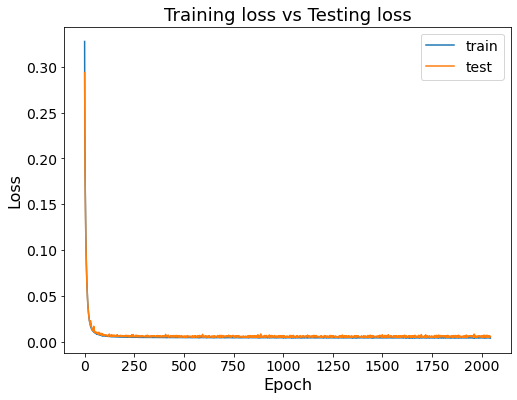

In [49]:
lr = 5e-4
EPOCHS = 6000

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)


energy_pararcnn.compile(
              optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
#               optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/energy_cnn_sc1_4layer_{}h.h5'.format(K), monitor='val_mae', mode='min', verbose=2, save_best_only=True)


history = energy_pararcnn.fit(train_X, train_y,
                              batch_size=512,
                              epochs=EPOCHS,
                              validation_data=(test_X, test_y),
                              verbose=2,
                              shuffle=True,
                              callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [50]:
from tensorflow.keras.models import load_model

saved_model = load_model('saved_model/energy_cnn_sc1_4layer_{}h.h5'.format(K))

In [51]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

error = inv_yhat - inv_y
print(error.shape)

inv_y.shape, inv_yhat.shape (6994, 24) (6994, 24)
(6994, 24)


In [52]:
print('MAE = {}'.format(float("{:.3f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.3f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 3.487
RMSE = 4.695
